In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import itertools
import warnings
from statsmodels.tsa.stattools import acf, pacf
import pickle
warnings.filterwarnings('ignore')
from math import sqrt


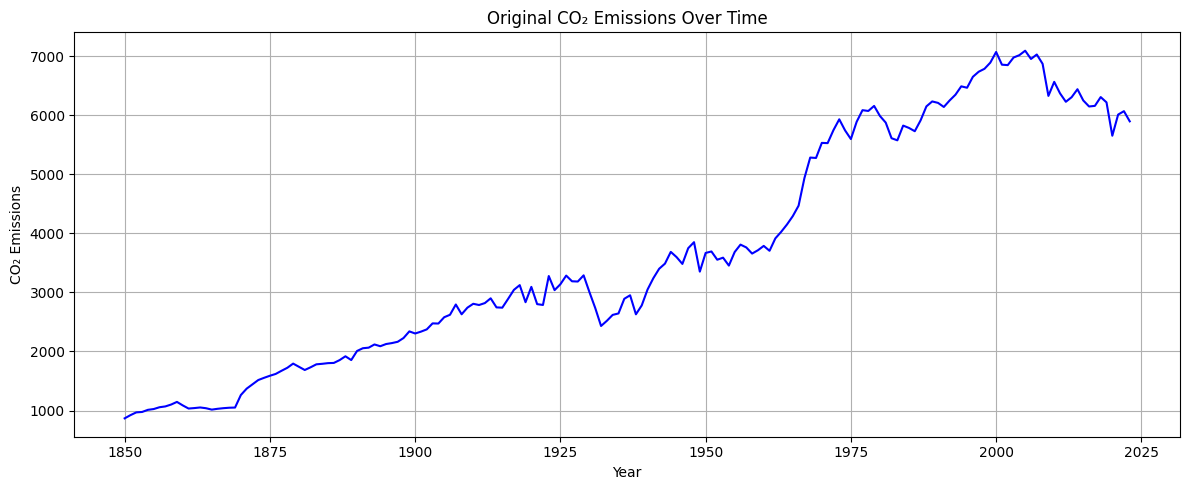

In [4]:
file_path= r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\processed_data\United_States.csv"

df= pd.read_csv(file_path)

# Plot original data
plt.figure(figsize=(12, 5))
plt.plot(df['year'], df['total_ghg'], label='Original CO₂', color='blue')
plt.title("Original CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
def create_sequences(data, seq_length):
    """Create input sequences and target values"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        # Only use past values of the target variable
        x = data[i:i+seq_length].reshape(-1, 1)  # Reshape for single feature
        y = data[i+seq_length]  # Target is the next CO2 value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [49]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # Input size is 1 since we only use past CO2 values
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step output
        out = lstm_out[:, -1, :]
        
        # Apply dropout and fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out.squeeze()

In [50]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        # Forward pass through GRU
        gru_out, _ = self.gru(x)
        
        # Take the last time step output
        out = gru_out[:, -1, :]
        
        # Apply dropout and fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out.squeeze()

In [51]:
def preprocess_data(df):
    # Use raw CO2 values
    co2_data = df['total_ghg'].values
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    co2_normalized = scaler.fit_transform(co2_data.reshape(-1, 1)).flatten()
    
    return co2_normalized, scaler

In [60]:
def train_model_with_early_stopping(X, y, device, patience=40):
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    
    # Print dataset info
    print(f"Training on full dataset - {len(X)} samples")
    print(f"Input shape: {X.shape}, Output shape: {y.shape}")
    
    # Initialize model
    model = LSTMModel(
        input_size=1,  # Single feature (past CO2 values)
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    ).to(device)
    
    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Early stopping parameters
    patience = patience
    min_loss = float('inf')
    counter = 0
    early_stop = False
    
    # Training loop
    epochs = 1000  # Set a high number, early stopping will determine when to stop
    train_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        train_out = model(X_tensor)
        train_loss = criterion(train_out, y_tensor)
        train_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Store training loss
        current_loss = train_loss.item()
        train_losses.append(current_loss)
        
        # Print progress
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {current_loss:.6f}")
        
        # Early stopping check
        if current_loss < min_loss:
            min_loss = current_loss
            counter = 0
            # Save best model
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                print(f"Best loss: {min_loss:.6f}")
                early_stop = True
        
        if early_stop:
            break
    
    # Load the best model before returning
    model.load_state_dict(best_model)
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss with Early Stopping')
    plt.axvline(x=epoch+1-counter, color='r', linestyle='--', 
                label=f'Early Stopping Point (epoch {epoch+1-counter})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, min_loss

def forecast_future(model, X, df, scaler, forecast_years=10, device='cpu'):
    # Use the last sequence from our data as the starting point
    x_input = torch.tensor(X[-1:], dtype=torch.float32).to(device)
    
    # Generate predictions for future years
    forecasted = []
    model.eval()
    
    with torch.no_grad():
        current_input = x_input.clone()
        
        for _ in range(forecast_years):
            # Get prediction for the next time step
            pred = model(current_input)
            forecasted.append(pred.item())
            
            # Update input sequence for next prediction
            # Shift the sequence by 1 and add the new prediction
            next_input = torch.cat((
                current_input[:, 1:], 
                pred.view(1, 1, 1)  # Reshape to match batch_size, 1, input_size
            ), dim=1)
            
            current_input = next_input
    
    # Convert normalized predictions to original scale
    forecasted_array = np.array(forecasted).reshape(-1, 1)
    forecasted_co2 = scaler.inverse_transform(forecasted_array).flatten()
    
    # Create the future years starting from the last year in the dataset
    last_year = df['year'].max()
    future_years = np.arange(last_year + 1, last_year + forecast_years + 1)

    # Filter for only last 20 years of historical data
    last_20_years_mask = df['year'] >= (last_year - 20 + 1)
    historical_years = df.loc[last_20_years_mask, 'year']
    historical_co2 = df.loc[last_20_years_mask, 'total_ghg']
    
    # Also get the normalized historical CO2 for consistent plotting
    historical_co2_normalized = scaler.transform(historical_co2.values.reshape(-1, 1)).flatten()

    # Calculate percentage changes for the forecasted data
    pct_changes = np.zeros(forecast_years - 1)
    for i in range(1, forecast_years):
        pct_changes[i-1] = (forecasted_co2[i] - forecasted_co2[i-1]) / forecasted_co2[i-1] * 100
    
    # Calculate metrics
    avg_annual_pct_change = np.mean(pct_changes)
    total_pct_change = (forecasted_co2[-1] - forecasted_co2[0]) / forecasted_co2[0] * 100
    min_annual_pct_change = np.min(pct_changes)
    max_annual_pct_change = np.max(pct_changes)
    
    # Plot the historical and forecasted values
    plt.figure(figsize=(14, 10))

    # Normalized scale plot
    plt.subplot(2, 1, 1)
    plt.plot(historical_years, historical_co2_normalized, label='Historical GHG (normalized)', color='blue')
    plt.plot(future_years, forecasted, label='Forecasted GHG (normalized)', color='red', linestyle='--', marker='o')
    plt.title('Historical (Last 20 Years) and Forecasted GHG Emissions (normalized scale)')
    plt.xlabel('Year')
    plt.ylabel('Normalized GHG')
    plt.grid(True)
    plt.legend()

    # Original scale plot
    plt.subplot(2, 1, 2)
    plt.plot(historical_years, historical_co2, label='Historical GHG', color='blue')
    plt.plot(future_years, forecasted_co2, label='Forecasted GHG', color='red', linestyle='--', marker='o')
    plt.title('Historical (Last 20 Years) and Forecasted GHG Emissions (original scale)')
    plt.xlabel('Year')
    plt.ylabel('GHG Emissions')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    

    # Create a dataframe with yearly forecasts and changes
    forecast_df = pd.DataFrame({
        'Year': future_years,
        'Forecasted_GHG': forecasted_co2,
    })
    
    # Add percentage change column (will be NaN for first row)
    forecast_df['Percentage_Change'] = forecast_df['Forecasted_GHG'].pct_change() * 100
    

    
    # Return forecasted values, years, and metrics
    metrics = {
        'avg_annual_pct_change': avg_annual_pct_change,
        'total_pct_change': total_pct_change,
        'min_annual_pct_change': min_annual_pct_change,
        'max_annual_pct_change': max_annual_pct_change
    }
    
    return forecasted, forecasted_co2, future_years, metrics

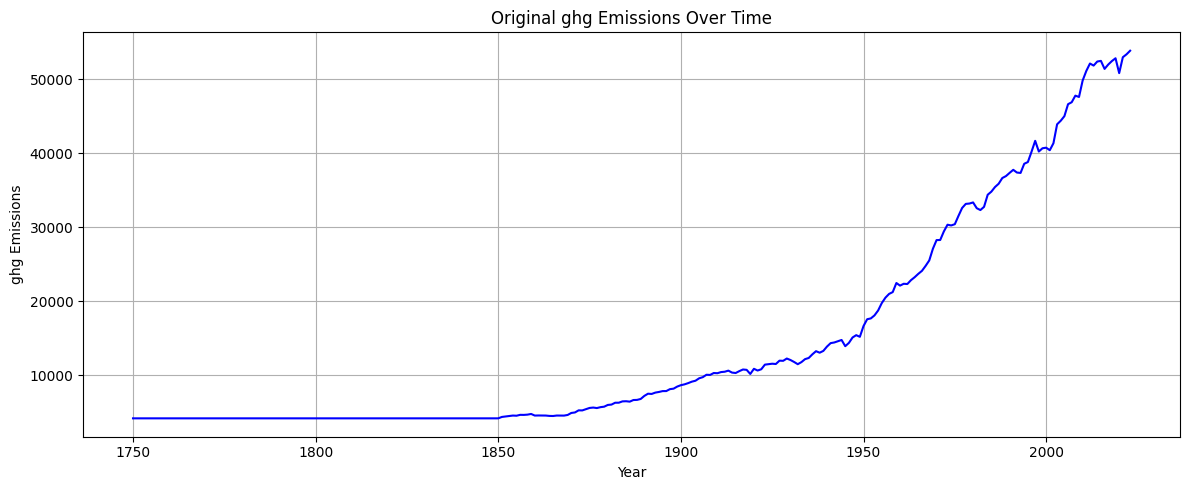

X shape: (269, 5, 1), y shape: (269,)
Using device: cuda
Training on full dataset - 269 samples
Input shape: (269, 5, 1), Output shape: (269,)
Epoch   1 | Train Loss: 0.090062
Epoch  10 | Train Loss: 0.084854
Epoch  20 | Train Loss: 0.074742
Epoch  30 | Train Loss: 0.028227
Epoch  40 | Train Loss: 0.009565
Epoch  50 | Train Loss: 0.002911
Epoch  60 | Train Loss: 0.002094
Epoch  70 | Train Loss: 0.001831
Epoch  80 | Train Loss: 0.001301
Epoch  90 | Train Loss: 0.001157
Epoch 100 | Train Loss: 0.001162
Epoch 110 | Train Loss: 0.000897
Epoch 120 | Train Loss: 0.001074
Epoch 130 | Train Loss: 0.001285
Epoch 140 | Train Loss: 0.000969
Epoch 150 | Train Loss: 0.000675
Epoch 160 | Train Loss: 0.000897
Epoch 170 | Train Loss: 0.000732
Epoch 180 | Train Loss: 0.000834
Epoch 190 | Train Loss: 0.000744
Epoch 200 | Train Loss: 0.000709
Epoch 210 | Train Loss: 0.000865
Epoch 220 | Train Loss: 0.000801
Epoch 230 | Train Loss: 0.000708
Epoch 240 | Train Loss: 0.000800
Epoch 250 | Train Loss: 0.000763

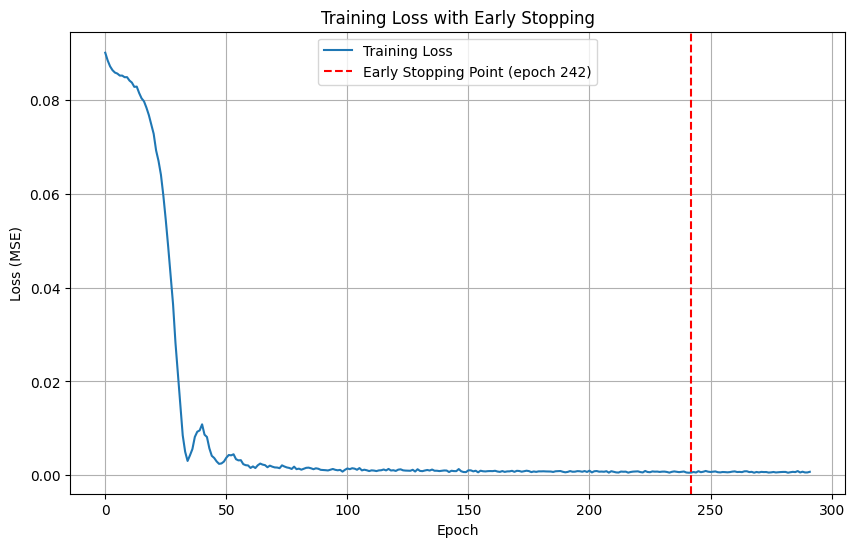

Training complete! Best loss: 0.000543


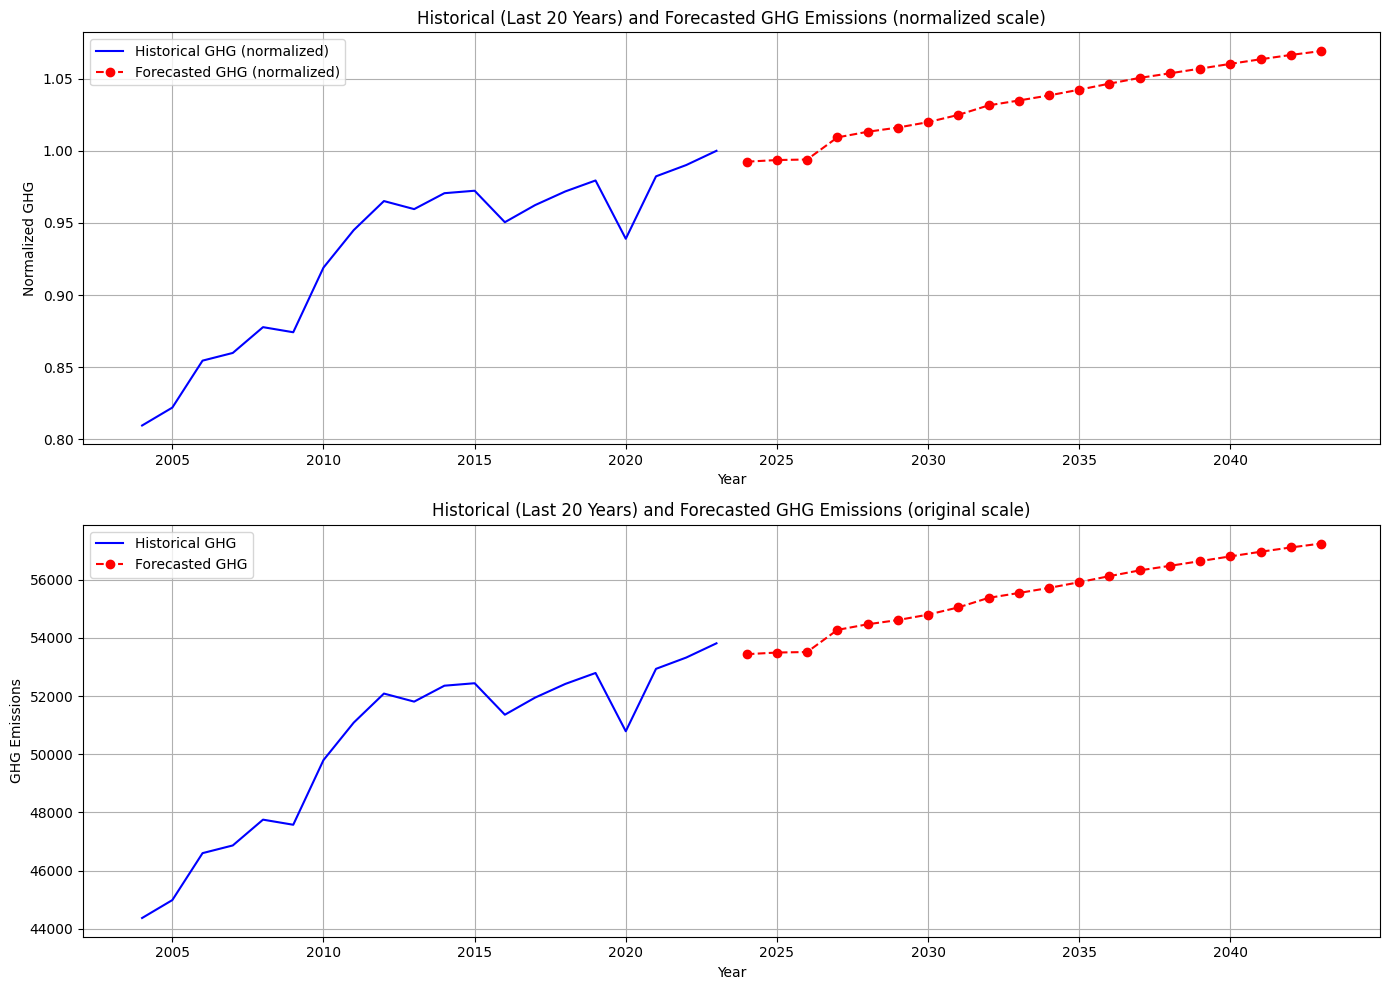


--- CO₂ Emission Forecast ---
    Year  Forecasted_Normalized_ghg  Forecasted_ghg
0   2024                   0.992455    53442.616253
1   2025                   0.993603    53499.595184
2   2026                   0.993971    53517.805737
3   2027                   1.009291    54277.649958
4   2028                   1.013201    54471.604180
5   2029                   1.016110    54615.881430
6   2030                   1.019882    54802.941657
7   2031                   1.024884    55051.066363
8   2032                   1.031492    55378.785379
9   2033                   1.034877    55546.677224
10  2034                   1.038402    55721.486714
11  2035                   1.042361    55917.841418
12  2036                   1.046577    56126.967160
13  2037                   1.050555    56324.279691
14  2038                   1.053714    56480.943665
15  2039                   1.056973    56642.562329
16  2040                   1.060279    56806.563738
17  2041                   1.0634

In [61]:
torch.cuda.empty_cache()
file_path = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\processed_data\World.csv"
df = pd.read_csv(file_path)

# Plot original CO2 data
plt.figure(figsize=(12, 5))
plt.plot(df['year'], df['total_ghg'], label='Original CO₂', color='blue')
plt.title("Original ghg Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("ghg Emissions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocess data - normalize raw CO2 values
data, scaler = preprocess_data(df)
    
# Create sequences
sequence_length = 5
X, y = create_sequences(data, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train the model with early stopping
model, best_loss = train_model_with_early_stopping(X, y, device, patience=50)
print(f"Training complete! Best loss: {best_loss:.6f}")

# Forecast future values
forecasted_norm, forecasted_co2, future_years ,metrics= forecast_future(
    model, X, df, scaler,forecast_years=20, device=device)

# Print forecast results in a table
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted_Normalized_ghg': forecasted_norm,
    'Forecasted_ghg': forecasted_co2
})
print("\n--- CO₂ Emission Forecast ---")
print(forecast_df)

# Print summary of metrics again for clarity
print("\n--- Summary of Forecasted CO2 Emission Changes ---")
print(f"Average annual percentage change: {metrics['avg_annual_pct_change']:.2f}%")
print(f"Total percentage change over forecast period: {metrics['total_pct_change']:.2f}%")
print(f"Minimum annual percentage change: {metrics['min_annual_pct_change']:.2f}%")
print(f"Maximum annual percentage change: {metrics['max_annual_pct_change']:.2f}%")

# Save the model and scaler
model_path = r'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\world_ghg_lstm_univariate_model.pth'
scaler_path = r'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\co2_scaler_full.pkl'

torch.save(model.state_dict(), model_path)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nModel saved to '{model_path}'")
print(f"Scaler saved to '{scaler_path}'")

In [62]:
def split_data(df, test_ratio=0.05):
    """Split data into training and testing sets"""
    total_samples = len(df)
    test_size = int(total_samples * test_ratio)
    train_size = total_samples - test_size
    
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    
    print(f"Training data: {len(df_train)} samples")
    print(f"Testing data: {len(df_test)} samples")
    
    return df_train, df_test

In [96]:
def grid_search_arima(df_train, target_column='log_ghg', original_column='total_ghg', d=0, p_range=range(1, 15), q_range=range(1, 15)):
    """Perform grid search for ARIMA model parameters based on original scale RMSE"""
    print("Performing grid search for ARIMA parameters...")
    
    # Create DataFrame to store results
    results_df = pd.DataFrame(columns=['p', 'd', 'q', 'aic', 'bic', 'rmse_log', 'rmse_original', 'r2_log', 'r2_original'])
    
    # Create combinations of p and q
    combinations = list(itertools.product(p_range, [d], q_range))
    
    # Split training data for validation (use last 5% for validation)
    val_size = int(len(df_train) * 0.05)
    train_data = df_train.iloc[:-val_size]
    val_data = df_train.iloc[-val_size:]
    
    print(f"Using {len(train_data)} samples for ARIMA model fitting")
    print(f"Using {len(val_data)} samples for ARIMA model validation")
    
    for order in combinations:
        try:
            # Fit the model
            model = ARIMA(train_data[target_column], order=order)
            results = model.fit()
            
            # Forecast validation period
            log_forecast = results.forecast(steps=len(val_data))
            
            # Calculate metrics on validation set in log scale
            rmse_log = np.sqrt(mean_squared_error(val_data[target_column], log_forecast))
            r2_log = r2_score(val_data[target_column], log_forecast)
            
            # Convert forecasts back to original scale and calculate metrics
            original_forecast = np.expm1(log_forecast)
            original_actual = val_data[original_column].values
            
            rmse_original = np.sqrt(mean_squared_error(original_actual, original_forecast))
            r2_original = r2_score(original_actual, original_forecast)
            
            # Store results
            results_df = results_df._append({
                'p': order[0],
                'd': order[1],
                'q': order[2],
                'aic': results.aic,
                'bic': results.bic,
                'rmse_log': rmse_log,
                'rmse_original': rmse_original,
                'r2_log': r2_log,
                'r2_original': r2_original
            }, ignore_index=True)
            
            print(f"ARIMA{order} - RMSE_log: {rmse_log:.4f}, RMSE_original: {rmse_original:.2f}, R²_original: {r2_original:.4f}")
            
        except Exception as e:
            print(f"ARIMA{order} - Error: {str(e)}")
            continue
    
    # Sort by original scale RMSE (ascending, lower is better)
    results_df = results_df.sort_values('rmse_original', ascending=True)
    
    # Get best model parameters
    best_p = int(results_df.iloc[0]['p'])
    best_d = int(results_df.iloc[0]['d'])
    best_q = int(results_df.iloc[0]['q'])
    best_order = (best_p, best_d, best_q)
    
    print("\nTop 5 ARIMA models by original scale RMSE:")
    print(results_df[['p', 'd', 'q', 'rmse_original', 'rmse_log', 'r2_original', 'aic', 'bic']].head(5).to_string(index=False))
    
    print(f"\nBest ARIMA model: ARIMA{best_order} with original scale RMSE: {results_df.iloc[0]['rmse_original']:.2f}")
    
    # Retrain best model on full training data
    best_model = ARIMA(df_train[target_column], order=best_order).fit()
    
    # Print final model information
    print(f"\nFinal model metrics on full training data:")
    print(f"AIC: {best_model.aic:.2f}")
    print(f"BIC: {best_model.bic:.2f}")
    
    return best_model, best_order

In [97]:
def get_arima_residuals(arima_model, df_train, target_column='log_ghg'):
    """Get ARIMA fitted values and residuals"""
    df_train['arima_pred'] = arima_model.fittedvalues
    df_train['residuals'] = df_train[target_column] - df_train['arima_pred']
    
    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df_train['residuals'])
    plt.title('ARIMA Residuals')
    plt.xlabel('Time')
    plt.ylabel('Residual Value')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    sns.histplot(df_train['residuals'], kde=True)
    plt.title('Distribution of Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df_train['residuals'].values.reshape(-1, 1)

In [98]:
def train_lstm_on_residuals(residuals, sequence_length=3, epochs=200):
    """Train LSTM model on ARIMA residuals"""
    print(f"Training LSTM model on residuals with sequence length = {sequence_length}...")
    
    # Create sequences from residuals
    X, y = create_sequences(residuals, sequence_length)
    
    # Convert to PyTorch tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    
    # Initialize model (smaller model for residuals)
    input_size = X.shape[2]  # Should be 1 for univariate residuals
    lstm_model = LSTMModel(
        input_size=input_size,
        hidden_size=32,  # Smaller hidden size for residuals
        num_layers=1,    # Fewer layers
        dropout=0.1      # Less dropout
    ).to(device)
    
    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-6)
    
    # Training loop
    train_losses = []
    
    for epoch in range(epochs):
        # Training
        lstm_model.train()
        optimizer.zero_grad()
        train_out = lstm_model(X_tensor)
        train_loss = criterion(train_out, y_tensor)
        train_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        
        optimizer.step()
        
        # Store training loss
        train_losses.append(train_loss.item())
        
        # Print progress
        if (epoch+1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss.item():.6f}")
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('LSTM Training Loss (Residuals)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()
    
    return lstm_model, X_tensor, y_tensor

In [99]:
def generate_hybrid_forecasts(arima_model, lstm_model, df_test, sequence_length, residuals, target_column='log_ghg', original_column='total_ghg'):
    """Generate forecasts using the hybrid model"""
    print("Generating hybrid forecasts...")
    
    # Generate ARIMA forecasts for test period
    arima_forecast = arima_model.forecast(steps=len(df_test))
    df_test['arima_pred'] = arima_forecast
    
    # Generate LSTM predictions for residuals
    # First, we need the last sequence from training data to start our forecasting
    last_sequence = residuals[-sequence_length:].reshape(1, sequence_length, 1)
    device = next(lstm_model.parameters()).device
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).to(device)
    
    # Forecast residuals iteratively
    residual_forecasts = []
    lstm_model.eval()
    
    with torch.no_grad():
        current_seq = last_sequence_tensor.clone()
        
        for _ in range(len(df_test)):
            # Predict next residual
            pred_residual = lstm_model(current_seq).item()
            residual_forecasts.append(pred_residual)
            
            # Update sequence for next prediction
            current_seq = torch.cat((
                current_seq[:, 1:], 
                torch.tensor([[[pred_residual]]], dtype=torch.float32).to(device)
            ), dim=1)
    
    # Add LSTM residual forecasts to test data
    df_test['lstm_residual_pred'] = residual_forecasts
    
    # Combine ARIMA and LSTM predictions
    df_test['hybrid_pred'] = df_test['arima_pred'] + df_test['lstm_residual_pred']
    
    # Convert log predictions back to original scale
    df_test['arima_pred_ghg'] = np.expm1(df_test['arima_pred'])
    df_test['hybrid_pred_ghg'] = np.expm1(df_test['hybrid_pred'])
    
    return df_test

In [100]:
def evaluate_models(df_test, target_column='log_ghg', original_column='total_ghg'):
    """Evaluate the ARIMA and hybrid models"""
    print("\n--- Model Evaluation ---")
    
    # Calculate metrics for ARIMA only
    arima_mse = mean_squared_error(df_test[target_column], df_test['arima_pred'])
    arima_mae = mean_absolute_error(df_test[target_column], df_test['arima_pred'])
    arima_r2 = r2_score(df_test[target_column], df_test['arima_pred'])
    
    # Calculate metrics for Hybrid model
    hybrid_mse = mean_squared_error(df_test[target_column], df_test['hybrid_pred'])
    hybrid_mae = mean_absolute_error(df_test[target_column], df_test['hybrid_pred'])
    hybrid_r2 = r2_score(df_test[target_column], df_test['hybrid_pred'])
    
    # Original scale metrics for ARIMA
    arima_orig_mse = mean_squared_error(df_test[original_column], df_test['arima_pred_ghg'])
    arima_orig_mae = mean_absolute_error(df_test[original_column], df_test['arima_pred_ghg'])
    arima_orig_r2 = r2_score(df_test[original_column], df_test['arima_pred_ghg'])
    
    # Original scale metrics for Hybrid
    hybrid_orig_mse = mean_squared_error(df_test[original_column], df_test['hybrid_pred_ghg'])
    hybrid_orig_mae = mean_absolute_error(df_test[original_column], df_test['hybrid_pred_ghg'])
    hybrid_orig_r2 = r2_score(df_test[original_column], df_test['hybrid_pred_ghg'])
    
    print("Log Scale Metrics:")
    print(f"ARIMA - MSE: {arima_mse:.6f}, MAE: {arima_mae:.6f}, R²: {arima_r2:.4f}")
    print(f"Hybrid - MSE: {hybrid_mse:.6f}, MAE: {hybrid_mae:.6f}, R²: {hybrid_r2:.4f}")
    print("\nOriginal Scale Metrics:")
    print(f"ARIMA - MSE: {arima_orig_mse:.2f}, MAE: {arima_orig_mae:.2f}, R²: {arima_orig_r2:.4f}")
    print(f"Hybrid - MSE: {hybrid_orig_mse:.2f}, MAE: {hybrid_orig_mae:.2f}, R²: {hybrid_orig_r2:.4f}")
    
    # Visualization
    plt.figure(figsize=(14, 10))
    
    # Log scale plot
    plt.subplot(2, 1, 1)
    plt.plot(df_test['year'], df_test[target_column], label='Actual log(GHG)', marker='o')
    plt.plot(df_test['year'], df_test['arima_pred'], label='ARIMA Prediction', marker='x')
    plt.plot(df_test['year'], df_test['hybrid_pred'], label='Hybrid Prediction', marker='^')
    plt.title('Predicted vs Actual CO₂ Emissions (log scale)')
    plt.xlabel('Year')
    plt.ylabel('log(GHG)')
    plt.legend()
    plt.grid(True)
    
    # Original scale plot
    plt.subplot(2, 1, 2)
    plt.plot(df_test['year'], df_test[original_column], label='Actual GHG', marker='o')
    plt.plot(df_test['year'], df_test['arima_pred_ghg'], label='ARIMA Prediction', marker='x')
    plt.plot(df_test['year'], df_test['hybrid_pred_ghg'], label='Hybrid Prediction', marker='^')
    plt.title('Predicted vs Actual GHG Emissions (original scale)')
    plt.xlabel('Year')
    plt.ylabel('GHG Emissions')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'log_scale': {
            'arima': {'mse': arima_mse, 'mae': arima_mae, 'r2': arima_r2},
            'hybrid': {'mse': hybrid_mse, 'mae': hybrid_mae, 'r2': hybrid_r2}
        },
        'original_scale': {
            'arima': {'mse': arima_orig_mse, 'mae': arima_orig_mae, 'r2': arima_orig_r2},
            'hybrid': {'mse': hybrid_orig_mse, 'mae': hybrid_orig_mae, 'r2': hybrid_orig_r2}
        }
    }

def forecast_future(arima_order, lstm_model, df, sequence_length, residuals, forecast_years=10, target_column='log_ghg', original_column='total_ghg'):
    """Generate future forecasts using the hybrid model"""
    print(f"Generating {forecast_years} year future forecast...")
    
    # Get last available year
    last_year = df['year'].max()
    future_years = np.arange(last_year+1, last_year + forecast_years + 1)
    
    # Refit ARIMA model on the entire dataset (like the second code)
    print("Refitting ARIMA model on complete dataset...")
    full_arima_model = ARIMA(df[target_column], order=arima_order)
    full_arima_model_fit = full_arima_model.fit()
    
    # ARIMA future forecast using the full dataset model
    arima_future = full_arima_model_fit.forecast(steps=forecast_years)
    
    # LSTM residual forecast
    # Use the last residuals from the data
    last_residual_seq = residuals[-sequence_length:].reshape(1, sequence_length, 1)
    device = next(lstm_model.parameters()).device
    last_residual_tensor = torch.tensor(last_residual_seq, dtype=torch.float32).to(device)
    
    lstm_future_residuals = []
    lstm_model.eval()
    
    with torch.no_grad():
        current_seq = last_residual_tensor.clone()
        
        for _ in range(forecast_years):
            # Predict next residual
            pred_residual = lstm_model(current_seq).item()
            lstm_future_residuals.append(pred_residual)
            
            # Update sequence for next prediction
            current_seq = torch.cat((
                current_seq[:, 1:], 
                torch.tensor([[[pred_residual]]], dtype=torch.float32).to(device)
            ), dim=1)
    
    # Combine forecasts
    hybrid_future = arima_future + np.array(lstm_future_residuals)
    
    # Convert to original scale
    arima_future_co2 = np.expm1(arima_future)
    hybrid_future_co2 = np.expm1(hybrid_future)
    
    # Last 20 years of historical data
    last_20_years_mask = df['year'] >= (last_year - 20 + 1)
    historical_years = df.loc[last_20_years_mask, 'year']
    historical_co2 = df.loc[last_20_years_mask, original_column]
    historical_log_co2 = df.loc[last_20_years_mask, target_column]
    
    # Plot the forecasts
    plt.figure(figsize=(14, 10))
    
    # Log scale plot
    plt.subplot(2, 1, 1)
    plt.plot(historical_years, historical_log_co2, label='Historical log(GHG)', color='blue')
    plt.plot(future_years, arima_future, label='ARIMA Forecast', color='green', linestyle='--', marker='x')
    plt.plot(future_years, hybrid_future, label='Hybrid Forecast', color='red', linestyle='--', marker='o')
    plt.title('Historical and Forecasted GHG Emissions (log scale)')
    plt.xlabel('Year')
    plt.ylabel('log(GHG)')
    plt.grid(True)
    plt.legend()
    
    # Original scale plot
    plt.subplot(2, 1, 2)
    plt.plot(historical_years, historical_co2, label='Historical GHG', color='blue')
    plt.plot(future_years, arima_future_co2, label='ARIMA Forecast', color='green', linestyle='--', marker='x')
    plt.plot(future_years, hybrid_future_co2, label='Hybrid Forecast', color='red', linestyle='--', marker='o')
    plt.title('Historical and Forecasted GHG Emissions (original scale)')
    plt.xlabel('Year')
    plt.ylabel('GHG Emissions')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'Year': future_years,
        'ARIMA_log_GHG': arima_future,
        'Hybrid_log_GHG': hybrid_future,
        'ARIMA_GHG': arima_future_co2,
        'Hybrid_GHG': hybrid_future_co2
    })
    
    # Calculate percentage changes for both ARIMA and Hybrid models
    # For ARIMA
    forecast_df['ARIMA_pct_change'] = forecast_df['ARIMA_GHG'].pct_change() * 100
    last_historical_co2 = df[original_column].iloc[-1]
    forecast_df['ARIMA_pct_change_from_last_historical'] = ((forecast_df['ARIMA_GHG'] - last_historical_co2) / last_historical_co2) * 100
    
    # For Hybrid
    forecast_df['Hybrid_pct_change'] = forecast_df['Hybrid_GHG'].pct_change() * 100
    forecast_df['Hybrid_pct_change_from_last_historical'] = ((forecast_df['Hybrid_GHG'] - last_historical_co2) / last_historical_co2) * 100
    
    print("\n--- CO₂ Emission Forecast ---")
    print(forecast_df[['Year', 'ARIMA_GHG', 'Hybrid_GHG']])
    
    # Print summary statistics for ARIMA model
    print("\nSummary of ARIMA Forecasted GHG Emission Changes:")
    print(f"Average annual percentage change: {forecast_df['ARIMA_pct_change'].mean():.2f}%")
    print(f"Total percentage change over forecast period: {forecast_df['ARIMA_pct_change_from_last_historical'].iloc[-1]:.2f}%")
    print(f"Minimum annual percentage change: {forecast_df['ARIMA_pct_change'].min():.2f}%")
    print(f"Maximum annual percentage change: {forecast_df['ARIMA_pct_change'].max():.2f}%")
    
    # Print summary statistics for Hybrid model
    print("\nSummary of Hybrid Forecasted GHG Emission Changes:")
    print(f"Average annual percentage change: {forecast_df['Hybrid_pct_change'].mean():.2f}%")
    print(f"Total percentage change over forecast period: {forecast_df['Hybrid_pct_change_from_last_historical'].iloc[-1]:.2f}%")
    print(f"Minimum annual percentage change: {forecast_df['Hybrid_pct_change'].min():.2f}%")
    print(f"Maximum annual percentage change: {forecast_df['Hybrid_pct_change'].max():.2f}%")
    
    # Save the forecast to a CSV file
    forecast_df.to_csv('co2_forecast_results.csv')
    print("Forecast results saved to 'co2_forecast_results.csv'")
    
    return forecast_df

In [101]:
def preprocess_data_new(df, target_column='total_ghg'):
    """Preprocess the data for time series modeling"""
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Log transform the target variable
    df['log_ghg'] = np.log1p(df[target_column])
    return df

In [102]:
def save_models(arima_model, lstm_model, arima_order):
    """Save the trained models"""
    print("Saving models...")
    
    # Save ARIMA results to pickle
    with open(r'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\world_best_arima_lstm_model_ghg.pkl', 'wb') as f:
        pickle.dump(arima_model, f)
    
    # Save LSTM model
    torch.save(lstm_model.state_dict(), r'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\GRU_residuals_model.pth')
    
    # Save parameter info
    with open('model_info.txt', 'w') as f:
        f.write(f"ARIMA Order: {arima_order}\n")
    
    print("Models saved as 'arima_model.pkl' and 'lstm_residuals_model.pth'")

def run_hybrid_model_pipeline(file_path, sequence_length=3, forecast_years=10):
    """Run the complete ARIMA+LSTM hybrid model pipeline"""
    # Load and preprocess data
    df = pd.read_csv(file_path)
    # Plot original data
    plt.figure(figsize=(12, 5))
    plt.plot(df['year'], df['total_ghg'], label='Original GHG', color='blue')
    plt.title("Original CO₂ Emissions Over Time")
    plt.xlabel("Year")
    plt.ylabel("CO₂ Emissions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    df = preprocess_data_new(df)
    
    # Split data
    df_train, df_test = split_data(df)
    
    # Grid search for best ARIMA model
    arima_model, arima_order = grid_search_arima(df_train)
    
    # Get residuals from best ARIMA model
    residuals = get_arima_residuals(arima_model, df_train)
    
    # Train LSTM on residuals
    lstm_model, X_tensor, y_tensor = train_lstm_on_residuals(residuals, sequence_length)
    
    # Generate hybrid forecasts for test set
    df_test = generate_hybrid_forecasts(arima_model, lstm_model, df_test, sequence_length, residuals)
    
    # Evaluate models
    evaluation_metrics = evaluate_models(df_test)
    
    # Generate future forecasts - pass arima_order instead of arima_model
    forecast_df = forecast_future(arima_order, lstm_model, df, sequence_length, residuals, forecast_years)
    
    # Save models
    save_models(arima_model, lstm_model, arima_order)
    
    return arima_model, lstm_model, forecast_df, evaluation_metrics

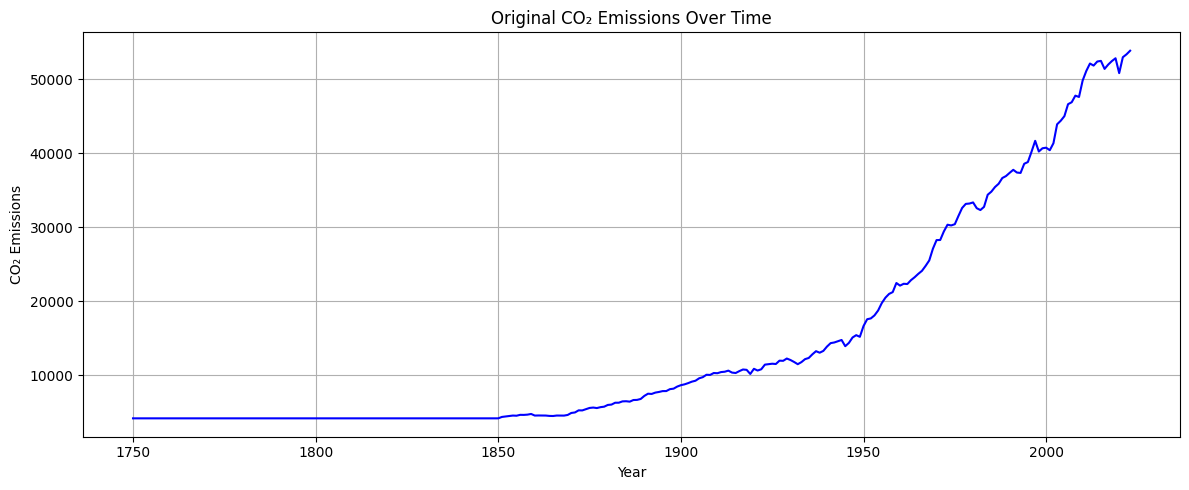

Training data: 261 samples
Testing data: 13 samples
Performing grid search for ARIMA parameters...
Using 248 samples for ARIMA model fitting
Using 13 samples for ARIMA model validation
ARIMA(1, 0, 1) - RMSE_log: 0.0903, RMSE_original: 4023.36, R²_original: -0.5924
ARIMA(1, 0, 2) - RMSE_log: 0.0859, RMSE_original: 3838.02, R²_original: -0.4491
ARIMA(1, 0, 3) - RMSE_log: 0.0792, RMSE_original: 3548.90, R²_original: -0.2390
ARIMA(1, 0, 4) - RMSE_log: 0.0811, RMSE_original: 3621.67, R²_original: -0.2903
ARIMA(1, 0, 5) - RMSE_log: 0.0716, RMSE_original: 3206.69, R²_original: -0.0116
ARIMA(1, 0, 6) - RMSE_log: 0.1283, RMSE_original: 5569.52, R²_original: -2.0515
ARIMA(1, 0, 7) - RMSE_log: 0.0861, RMSE_original: 3840.12, R²_original: -0.4507
ARIMA(1, 0, 8) - RMSE_log: 0.0669, RMSE_original: 3019.92, R²_original: 0.1029
ARIMA(1, 0, 9) - RMSE_log: 0.1698, RMSE_original: 7104.47, R²_original: -3.9652
ARIMA(1, 0, 10) - RMSE_log: 0.1833, RMSE_original: 7625.25, R²_original: -4.7198
ARIMA(1, 0, 11)

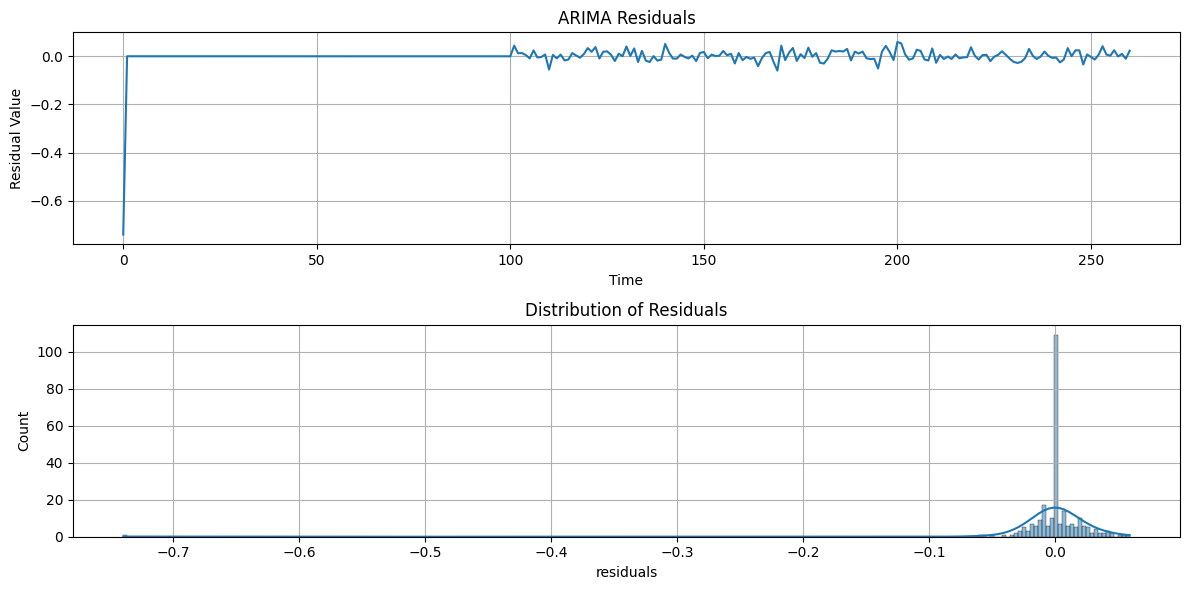

Training LSTM model on residuals with sequence length = 4...
Using device: cuda
Epoch   1 | Train Loss: 0.004889
Epoch  20 | Train Loss: 0.000342
Epoch  40 | Train Loss: 0.000294
Epoch  60 | Train Loss: 0.000277
Epoch  80 | Train Loss: 0.000274
Epoch 100 | Train Loss: 0.000273
Epoch 120 | Train Loss: 0.000273
Epoch 140 | Train Loss: 0.000272
Epoch 160 | Train Loss: 0.000272
Epoch 180 | Train Loss: 0.000272
Epoch 200 | Train Loss: 0.000272


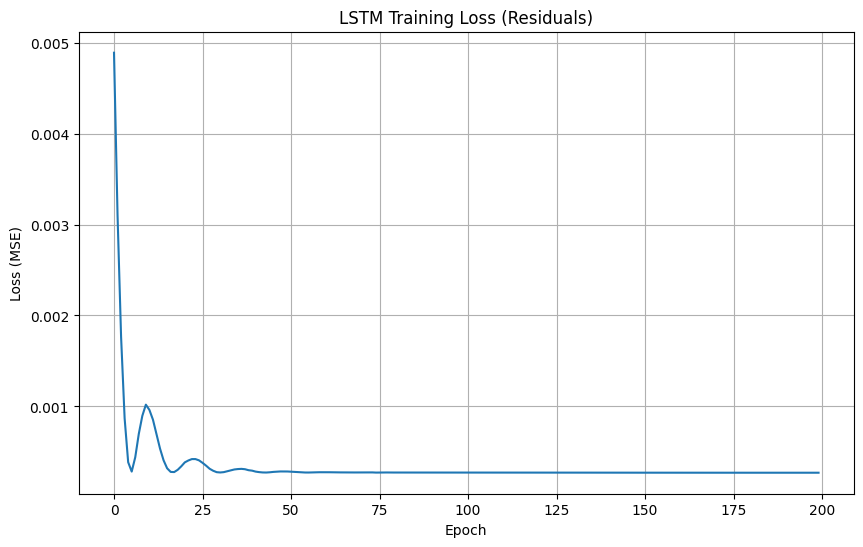

Generating hybrid forecasts...

--- Model Evaluation ---
Log Scale Metrics:
ARIMA - MSE: 0.004120, MAE: 0.051139, R²: -15.1812
Hybrid - MSE: 0.004275, MAE: 0.052288, R²: -15.7885

Original Scale Metrics:
ARIMA - MSE: 12473392.52, MAE: 2791.66, R²: -16.9448
Hybrid - MSE: 12962560.90, MAE: 2856.72, R²: -17.6486


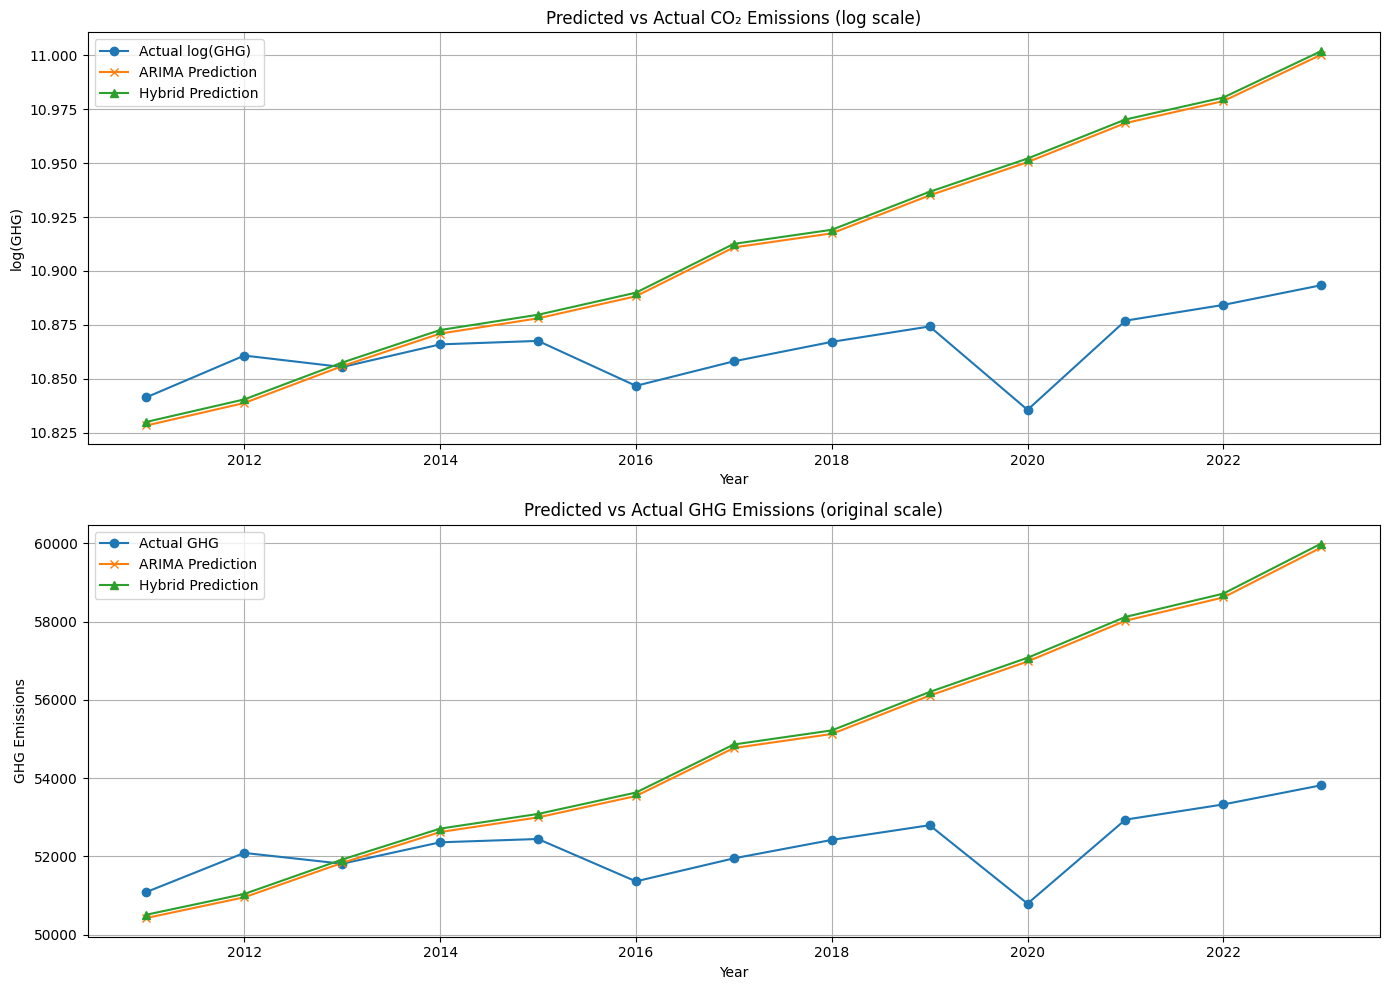

Generating 10 year future forecast...
Refitting ARIMA model on complete dataset...


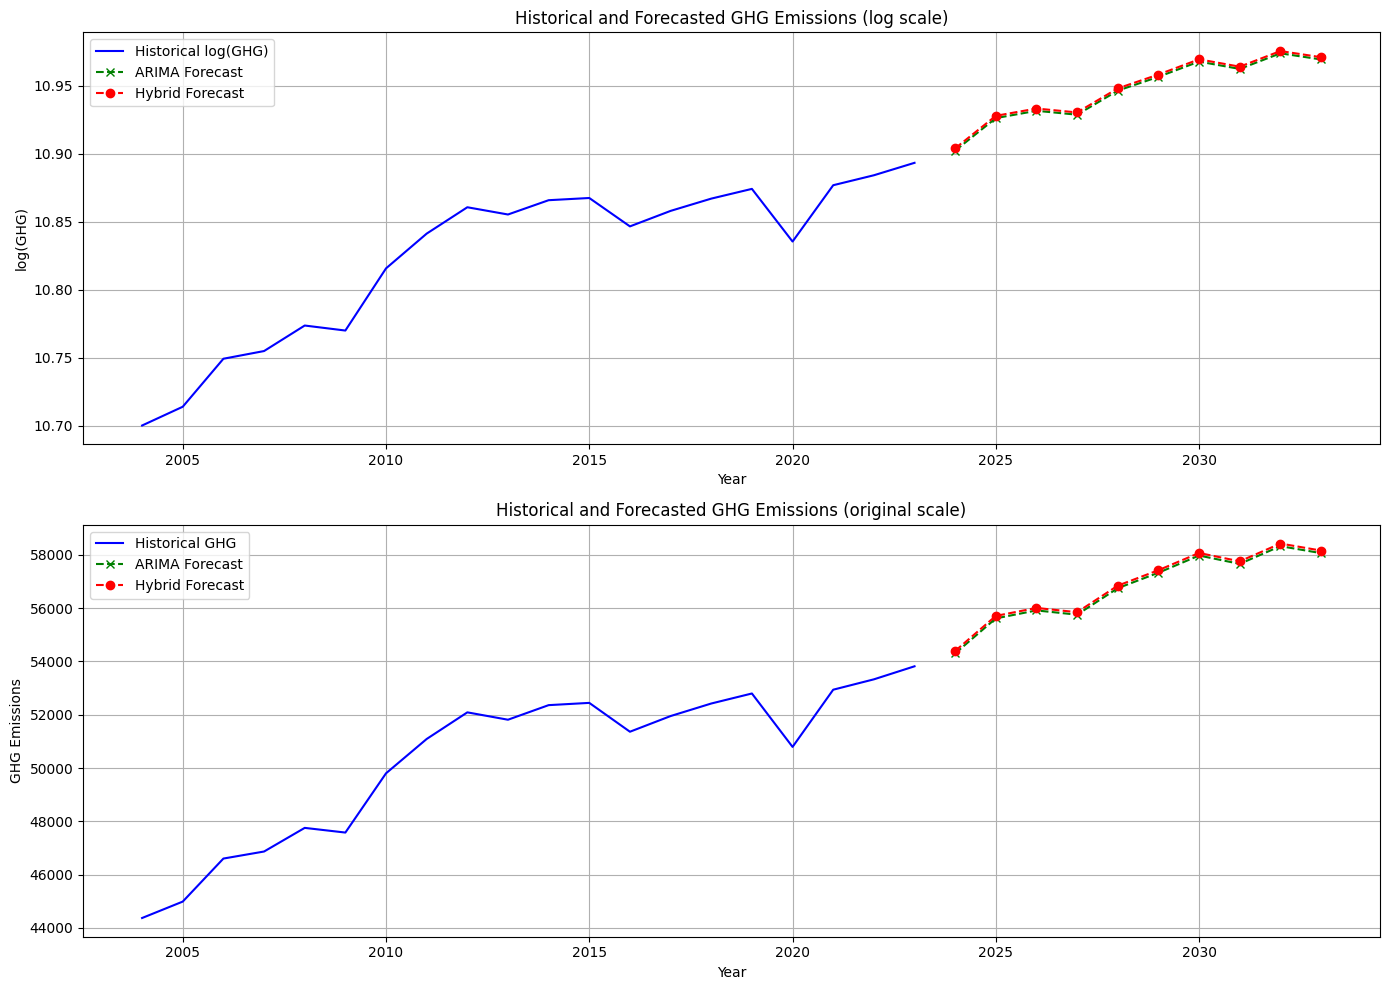


--- CO₂ Emission Forecast ---
     Year     ARIMA_GHG    Hybrid_GHG
274  2024  54301.675086  54392.438504
275  2025  55614.847171  55707.562660
276  2026  55914.045202  56007.115926
277  2027  55753.628092  55846.402674
278  2028  56748.686157  56843.012311
279  2029  57328.523391  57423.812889
280  2030  57973.227516  58069.588600
281  2031  57660.357527  57756.198148
282  2032  58326.168528  58423.115814
283  2033  58063.219836  58159.730067

Summary of ARIMA Forecasted GHG Emission Changes:
Average annual percentage change: 0.75%
Total percentage change over forecast period: 7.89%
Minimum annual percentage change: -0.54%
Maximum annual percentage change: 2.42%

Summary of Hybrid Forecasted GHG Emission Changes:
Average annual percentage change: 0.75%
Total percentage change over forecast period: 8.07%
Minimum annual percentage change: -0.54%
Maximum annual percentage change: 2.42%
Forecast results saved to 'co2_forecast_results.csv'
Saving models...
Models saved as 'arima_model.pkl

In [103]:
file_path = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\processed_data\World.csv"
    
# Run the hybrid model pipeline
arima_model, lstm_model, forecast_df, evaluation_metrics = run_hybrid_model_pipeline(
    file_path, sequence_length=4, forecast_years=10
)

In [104]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                log_ghg   No. Observations:                  261
Model:               ARIMA(12, 0, 14)   Log Likelihood                 694.788
Date:                Sat, 26 Apr 2025   AIC                          -1333.575
Time:                        19:39:22   BIC                          -1233.769
Sample:                             0   HQIC                         -1293.456
                                - 261                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0872      7.386      1.230      0.219      -5.389      23.563
ar.L1          1.4820      1.676      0.885      0.376      -1.802       4.766
ar.L2         -0.2392      2.605     -0.092      0.9

   year  total_ghg    co2  temperature_change_from_co2  \
0  1750   4219.061  9.306                        0.001   
1  1751   4219.061  9.407                        0.001   
2  1752   4219.061  9.505                        0.001   
3  1753   4219.061  9.610                        0.001   
4  1754   4219.061  9.734                        0.001   

   temperature_change_from_ghg  coal_pc1       oil_pc1       gas_pc1  \
0                        0.002  0.000000  0.000000e+00  0.000000e+00   
1                        0.002  0.000004  3.330669e-16  6.938894e-16   
2                        0.002  0.000008  2.498002e-16  6.106227e-16   
3                        0.002  0.000012  2.498002e-16  6.106227e-16   
4                        0.002  0.000016  2.498002e-16  6.106227e-16   

     cement_pc1  land_use_pc1       ghg_pc1  nonco2_ghg_pc1   log_ghg  
0  0.000000e+00      0.041529  1.665335e-16    8.326673e-16  8.347605  
1  1.665335e-16      0.041529  0.000000e+00    2.775558e-17  8.347605  
2 

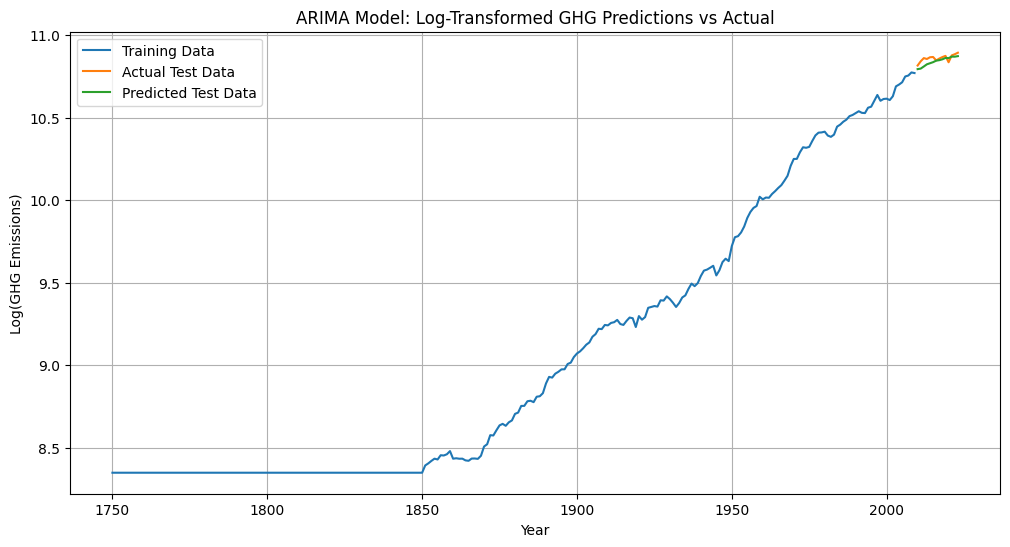

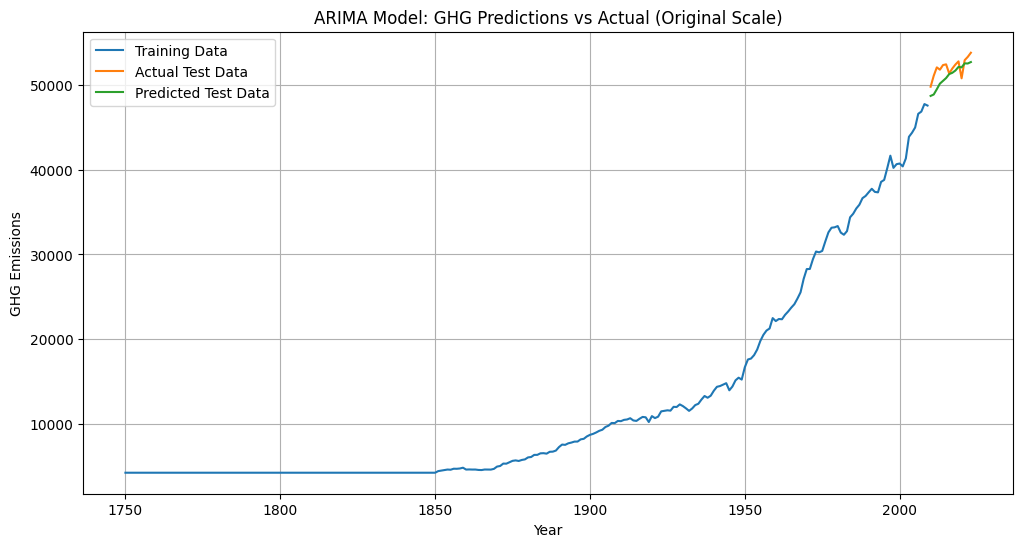

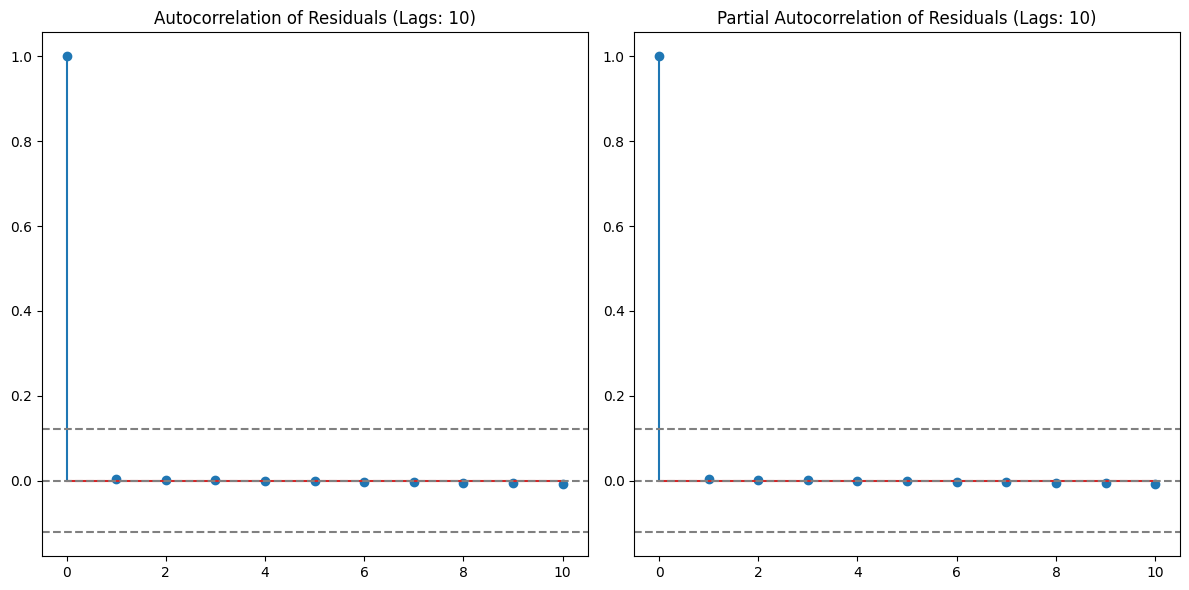


Full ARIMA model saved to 'C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\world_full_arima_ghg_model.pkl'

Forecasted ghg emissions for the next 10 years:
      forecast_ghg  pct_change  pct_change_from_last_historical
year                                                           
2024  53797.743225         NaN                        -0.035507
2025  54784.086600    1.833429                         1.797271
2026  54717.740940   -0.121104                         1.673990
2027  54456.633669   -0.477189                         1.188813
2028  55092.662152    1.167954                         2.370652
2029  55340.573380    0.449990                         2.831309
2030  55679.013066    0.611558                         3.460182
2031  55510.106114   -0.303358                         3.146327
2032  56299.549623    1.422162                         4.613235
2033  56050.510835   -0.442346                         4.150482


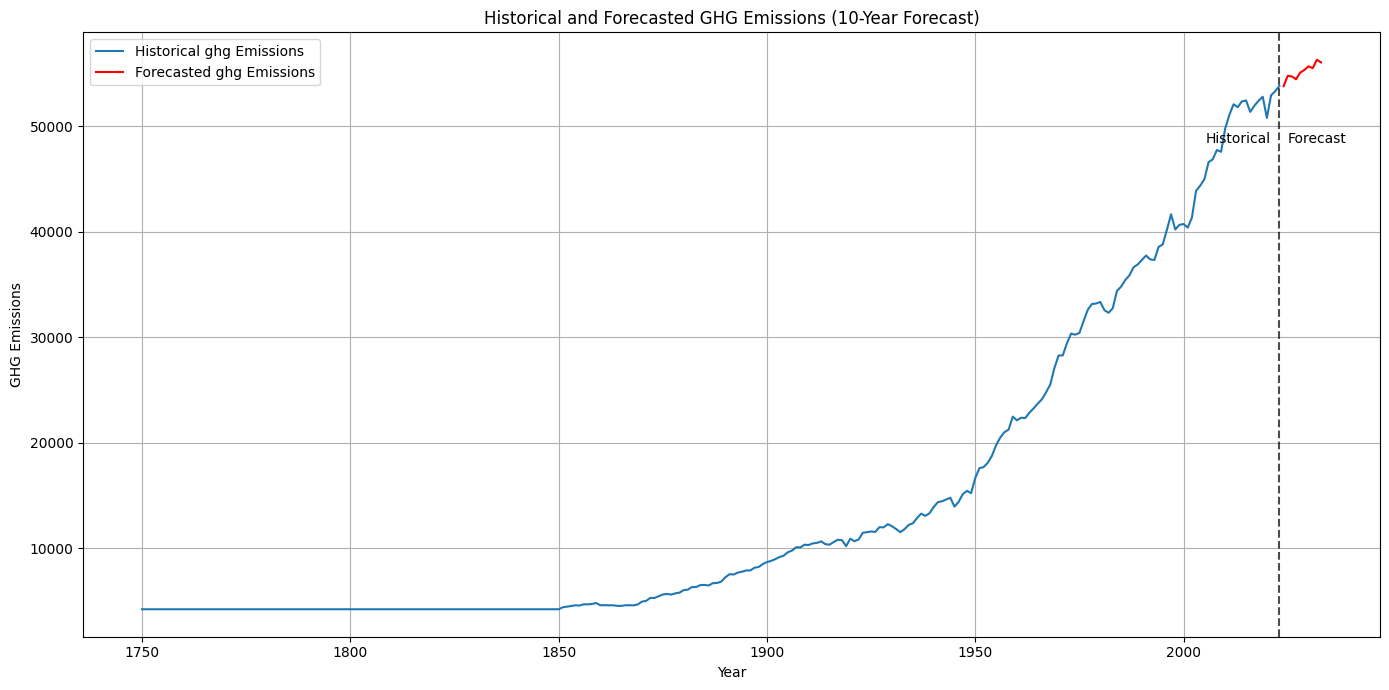

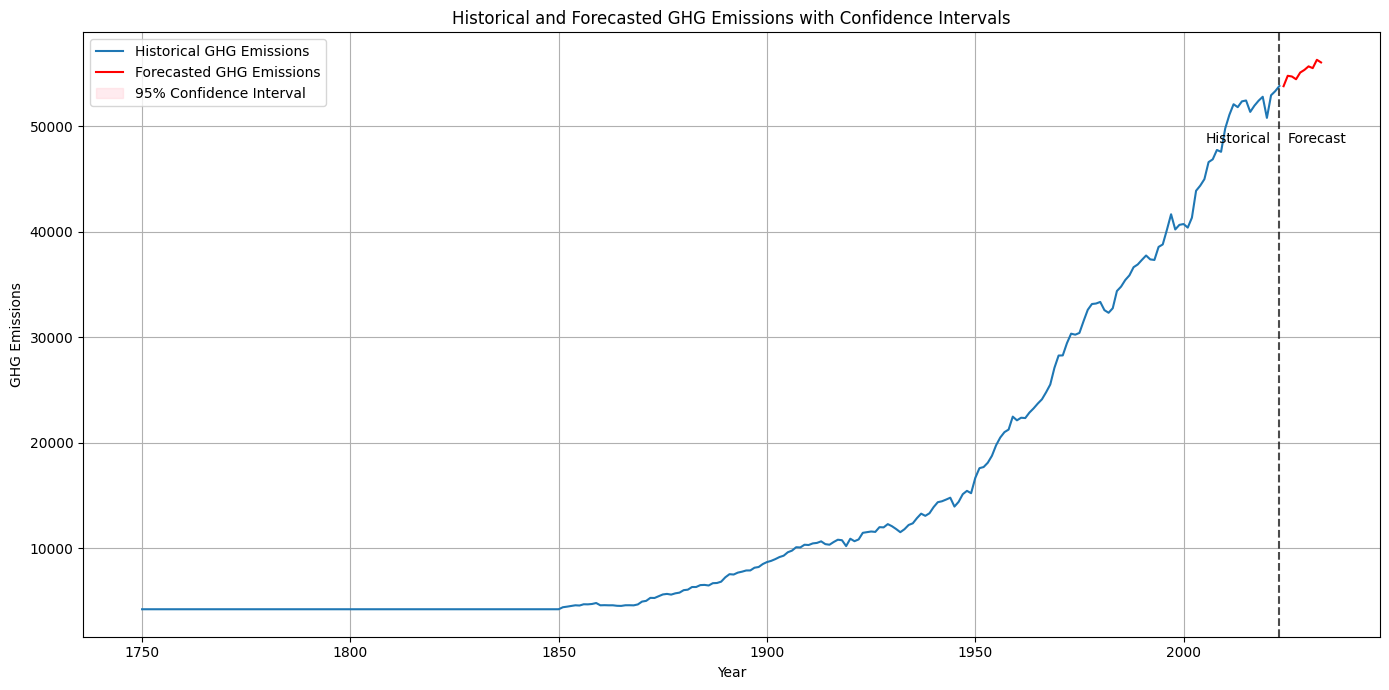

Forecast results saved to 'GHG_forecast_results.csv'

Summary of Forecasted CO2 Emission Changes:
Average annual percentage change: 0.46%
Total percentage change over forecast period: 4.15%
Minimum annual percentage change: -0.48%
Maximum annual percentage change: 1.83%


In [106]:
file_path = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\data\processed_data\World.csv"
df= pd.read_csv(file_path)

df_final = preprocess_data_new(df)

print(df_final.head())

df_final.set_index('year', inplace=True)

# Split the data into training and testing sets (80% for training)
train_size = int(len(df_final) * 0.95)
train_data = df_final.iloc[:train_size]
test_data = df_final.iloc[train_size:]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Function to fit ARIMA model and make predictions
def fit_arima_model(train_series, test_series, order=(1, 1, 1)):
    # Fit the ARIMA model
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    
    # Summary of the model
    print(model_fit.summary())
    
    # Calculate residuals
    residuals = pd.Series(model_fit.resid, index=train_series.index)
    
    # Make predictions for test data
    predictions = model_fit.forecast(steps=len(test_series))
    
    # Convert predictions back to original scale
    original_scale_preds = np.expm1(predictions)
    original_scale_actual = np.expm1(test_series)
    
    # Evaluate the model
    mse = mean_squared_error(original_scale_actual, original_scale_preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(original_scale_actual, original_scale_preds)
    r2 = r2_score(original_scale_actual, original_scale_preds)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")
    
    return model_fit, predictions, original_scale_preds, original_scale_actual, residuals

# Function to plot results
def plot_results(train_series, test_series, predictions, original_scale_preds, original_scale_actual):
    # Plot log-transformed results
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data')
    plt.plot(test_series.index, test_series, label='Actual Test Data')
    plt.plot(test_series.index, predictions, label='Predicted Test Data')
    plt.title('ARIMA Model: Log-Transformed GHG Predictions vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Log(GHG Emissions)')
    plt.legend()
    plt.grid(True)
  
    
    # Plot original scale results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, np.expm1(train_series), label='Training Data')
    plt.plot(test_series.index, original_scale_actual, label='Actual Test Data')
    plt.plot(test_series.index, original_scale_preds, label='Predicted Test Data')
    plt.title('ARIMA Model: GHG Predictions vs Actual (Original Scale)')
    plt.xlabel('Year')
    plt.ylabel('GHG Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform a grid search to find the best ARIMA parameters
# Define the p and q parameters to test (keeping d=1)
p_values = range(1, 14)
q_values = range(1, 15)

# Create a DataFrame to store results
grid_results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC', 'RMSE'])

# Perform the grid search
print("\nPerforming grid search for ARIMA parameters (keeping d=1)...")
best_rmse = float('inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
    try:
        # Define the order
        order = (p, 0, q)
        
        # Fit the model
        model = ARIMA(train_data['log_ghg'], order=order)
        model_fit = model.fit()
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test_data))
        
        # Convert to original scale
        original_scale_preds = np.expm1(predictions)
        original_scale_actual = np.expm1(test_data['log_ghg'])
        
        # Calculate RMSE
        mse = mean_squared_error(original_scale_actual, original_scale_preds)
        rmse = sqrt(mse)
        
        # Store the results
        grid_results = pd.concat([grid_results, pd.DataFrame({
            'p': [p],
            'd': [0],
            'q': [q],
            'AIC': [model_fit.aic],
            'BIC': [model_fit.bic],
            'RMSE': [rmse]
        })], ignore_index=True)
        
        print(f"ARIMA({p},1,{q}) - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}, RMSE: {rmse:.4f}")
        
        # Update the best model if this one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            
    except Exception as e:
        print(f"Error with ARIMA({p},1,{q}): {str(e)}")
        continue

# Sort the results by RMSE
grid_results = grid_results.sort_values('RMSE')
print("\nGrid search results (sorted by RMSE):")
print(grid_results)

print(f"\nBest ARIMA order based on RMSE: {best_order}")

# Fit the best model
print(f"\nFitting ARIMA{best_order} model on training data...")
model_fit, predictions, original_scale_preds, original_scale_actual, residuals = fit_arima_model(
    train_data['log_ghg'], 
    test_data['log_ghg'],
    order=best_order
)

# Plot the results
plot_results(train_data['log_ghg'], test_data['log_ghg'], predictions, original_scale_preds, original_scale_actual)

# Plot the residuals - only ACF and PACF for the best model
plt.figure(figsize=(12, 6))
nlags=10
# # ACF of residuals
plt.subplot(121)
plt.stem(acf(residuals, nlags=nlags))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title(f'Autocorrelation of Residuals (Lags: {nlags})')

# # PACF of residuals
plt.subplot(122)
plt.stem(pacf(residuals, nlags=nlags))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title(f'Partial Autocorrelation of Residuals (Lags: {nlags})')

plt.tight_layout()
plt.show()

# Make forecast for the next 10 years
last_year = df_final.index.max()
forecast_years = list(range(last_year + 1, last_year + 11))

# Fit the model on the entire dataset using the best parameters from grid search
full_model = ARIMA(df_final['log_ghg'], order=best_order)
full_model_fit = full_model.fit()

full_model_path = r"C:\Users\acksh\OneDrive\Desktop\MSAI\Machine Learning\Final_project\models\world_full_arima_ghg_model.pkl"
with open(full_model_path, 'wb') as f:
    pickle.dump(full_model_fit, f)
print(f"\nFull ARIMA model saved to '{full_model_path}'")

# Plot residuals for the full model - only ACF and PACF
# Just use the final model directly, don't create redundant plots
# We already have the ACF/PACF plots for the best model above

# Generate forecasts in log-transformed scale
forecast = full_model_fit.forecast(steps=10)

# Convert forecasts back to original scale
forecast_original = np.expm1(forecast)

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({
    'year': forecast_years,
    'forecast_log_ghg': forecast,
    'forecast_ghg': forecast_original
})
forecast_df.set_index('year', inplace=True)

# Calculate percentage change from previous year
forecast_df['pct_change'] = forecast_df['forecast_ghg'].pct_change() * 100
# Calculate percentage change from the last historical year
last_historical_co2 = df_final['total_ghg'].iloc[-1]
forecast_df['pct_change_from_last_historical'] = ((forecast_df['forecast_ghg'] - last_historical_co2) / last_historical_co2) * 100

print("\nForecasted ghg emissions for the next 10 years:")
print(forecast_df[['forecast_ghg', 'pct_change', 'pct_change_from_last_historical']])

# Plot the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['total_ghg'], label='Historical ghg Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_ghg'], label='Forecasted ghg Emissions', color='red')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['total_ghg'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['total_ghg'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted GHG Emissions (10-Year Forecast)')
plt.xlabel('Year')
plt.ylabel('GHG Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a DataFrame with confidence intervals for the forecast
conf_int = full_model_fit.get_forecast(steps=10).conf_int()
conf_int_original = np.expm1(conf_int)
forecast_df['lower_ci'] = conf_int_original.iloc[:, 0]
forecast_df['upper_ci'] = conf_int_original.iloc[:, 1]

# Plot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(df_final.index, df_final['total_ghg'], label='Historical GHG Emissions')
plt.plot(forecast_df.index, forecast_df['forecast_ghg'], label='Forecasted GHG Emissions', color='red')

# Add confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['lower_ci'], 
                 forecast_df['upper_ci'], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=last_year, color='black', linestyle='--', alpha=0.7)
plt.text(last_year - 2, df_final['total_ghg'].max() * 0.9, 'Historical', ha='right')
plt.text(last_year + 2, df_final['total_ghg'].max() * 0.9, 'Forecast', ha='left')

plt.title('Historical and Forecasted GHG Emissions with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('GHG Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Save the forecast to a CSV file
forecast_df.to_csv('co2_forecast_results.csv')
print("Forecast results saved to 'GHG_forecast_results.csv'")

# Print a summary of forecasted percentage changes
print("\nSummary of Forecasted CO2 Emission Changes:")
print(f"Average annual percentage change: {forecast_df['pct_change'].mean():.2f}%")
print(f"Total percentage change over forecast period: {forecast_df['pct_change_from_last_historical'].iloc[-1]:.2f}%")
print(f"Minimum annual percentage change: {forecast_df['pct_change'].min():.2f}%")
print(f"Maximum annual percentage change: {forecast_df['pct_change'].max():.2f}%")